In [1]:
# Import libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree

# Suppress all warnings
import warnings
warnings.simplefilter("ignore")

plt.style.use('fivethirtyeight')

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Initial `XGBoost`

In [10]:
# Import data
df = pd.read_csv('df_post_eda.csv')

# Predictive variable
pred_var = 'Additional_Doses_Vax_Pct' 

In [11]:
df.columns

Index(['Date', 'MMWR_week', 'Location', 'Distributed', 'Distributed_Janssen',
       'Distributed_Moderna', 'Distributed_Pfizer', 'Distributed_Unk_Manuf',
       'Dist_Per_100K', 'Distributed_Per_100k_5Plus',
       'Distributed_Per_100k_12Plus', 'Distributed_Per_100k_18Plus',
       'Distributed_Per_100k_65Plus', 'Administered', 'Administered_5Plus',
       'Administered_12Plus', 'Administered_18Plus', 'Administered_65Plus',
       'Administered_Janssen', 'Administered_Moderna', 'Administered_Pfizer',
       'Administered_Unk_Manuf', 'Admin_Per_100K', 'Admin_Per_100k_5Plus',
       'Admin_Per_100k_12Plus', 'Admin_Per_100k_18Plus',
       'Admin_Per_100k_65Plus', 'Recip_Administered',
       'Administered_Dose1_Pop_Pct', 'Administered_Dose1_Recip_5PlusPop_Pct',
       'Administered_Dose1_Recip_12PlusPop_Pct',
       'Administered_Dose1_Recip_18PlusPop_Pct',
       'Administered_Dose1_Recip_65PlusPop_Pct', 'Series_Complete_Pop_Pct',
       'Series_Complete_5PlusPop_Pct', 'Series_Complet

In [7]:
# Tune with for-loop
df['rolling_mean'] = df[pred_var].shift().rolling(window=3).mean()
df['rolling_std'] = df[pred_var].shift().rolling(window=3).std()

In [8]:
# splitting the data (try 70,15,15)
train_size = int(len(df) * 0.8)

# Create two x_test and x_test2
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [12]:
# Set up XGBoost data structures
X_train, y_train = train.drop(pred_var, axis=1), train[pred_var]
X_test, y_test = test.drop(pred_var, axis=1), test[pred_var]

# Convert categorical columns to one-hot encoded columns
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Ensure columns in X_train and X_test are the same after one-hot encoding
missing_cols = set(X_train.columns) - set(X_test.columns)
    # Create a new DataFrame missing_data with the same index as X_test, columns as missing_cols, and fill it with 
    # zeros.
missing_data = pd.DataFrame(0, index=X_test.index, columns=list(missing_cols))
    # Concatenate X_test and missing_data side by side (using axis=1) and then reorder the columns to match 
    # X_train.
X_test = pd.concat([X_test, missing_data], axis=1)[X_train.columns]

data_train = xgb.DMatrix(X_train, label=y_train)
data_test = xgb.DMatrix(X_test, label=y_test)


/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [17]:
# Parameters for the model
params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'learning_rate': 0.01
}

# Training the model with the specified number of boosting rounds
# Put one test group in evals and one just after model is trained
model = xgb.train(params, data_train, num_boost_round=1000, evals=[(data_train, 'train'), (data_test, 'test')])


[0]	train-rmse:47.79882	test-rmse:30.43308
[1]	train-rmse:47.32259	test-rmse:30.12923
[2]	train-rmse:46.85111	test-rmse:29.82266
[3]	train-rmse:46.38437	test-rmse:29.52281
[4]	train-rmse:45.92225	test-rmse:29.22581
[5]	train-rmse:45.46477	test-rmse:28.93159
[6]	train-rmse:45.01186	test-rmse:28.64017
[7]	train-rmse:44.56349	test-rmse:28.35367
[8]	train-rmse:44.11959	test-rmse:28.06803
[9]	train-rmse:43.68013	test-rmse:27.78554
[10]	train-rmse:43.24505	test-rmse:27.50787
[11]	train-rmse:42.81433	test-rmse:27.23454
[12]	train-rmse:42.38789	test-rmse:26.96070
[13]	train-rmse:41.96573	test-rmse:26.69288
[14]	train-rmse:41.54778	test-rmse:26.42637
[15]	train-rmse:41.13400	test-rmse:26.16076
[16]	train-rmse:40.72435	test-rmse:25.90125
[17]	train-rmse:40.31880	test-rmse:25.64059
[18]	train-rmse:39.91730	test-rmse:25.38654
[19]	train-rmse:39.51982	test-rmse:25.12804
[20]	train-rmse:39.12629	test-rmse:24.87904
[21]	train-rmse:38.73671	test-rmse:24.63009
[22]	train-rmse:38.35099	test-rmse:24.3847

[187]	train-rmse:7.37835	test-rmse:4.34481
[188]	train-rmse:7.30526	test-rmse:4.30119
[189]	train-rmse:7.23289	test-rmse:4.25840
[190]	train-rmse:7.16124	test-rmse:4.21494
[191]	train-rmse:7.09031	test-rmse:4.17246
[192]	train-rmse:7.02010	test-rmse:4.13026
[193]	train-rmse:6.95057	test-rmse:4.08924
[194]	train-rmse:6.88175	test-rmse:4.04810
[195]	train-rmse:6.81361	test-rmse:4.00820
[196]	train-rmse:6.74613	test-rmse:3.96899
[197]	train-rmse:6.67933	test-rmse:3.92961
[198]	train-rmse:6.61320	test-rmse:3.89160
[199]	train-rmse:6.54772	test-rmse:3.85342
[200]	train-rmse:6.48293	test-rmse:3.81795
[201]	train-rmse:6.41876	test-rmse:3.78110
[202]	train-rmse:6.35522	test-rmse:3.74398
[203]	train-rmse:6.29233	test-rmse:3.70738
[204]	train-rmse:6.23005	test-rmse:3.67043
[205]	train-rmse:6.16841	test-rmse:3.63348
[206]	train-rmse:6.10736	test-rmse:3.59804
[207]	train-rmse:6.04695	test-rmse:3.56419
[208]	train-rmse:5.98712	test-rmse:3.52933
[209]	train-rmse:5.92788	test-rmse:3.49484
[210]	train

[378]	train-rmse:1.13267	test-rmse:1.75580
[379]	train-rmse:1.12198	test-rmse:1.75654
[380]	train-rmse:1.11140	test-rmse:1.75710
[381]	train-rmse:1.10091	test-rmse:1.75791
[382]	train-rmse:1.09053	test-rmse:1.75867
[383]	train-rmse:1.08030	test-rmse:1.75860
[384]	train-rmse:1.07015	test-rmse:1.75954
[385]	train-rmse:1.06010	test-rmse:1.76052
[386]	train-rmse:1.05018	test-rmse:1.76051
[387]	train-rmse:1.04032	test-rmse:1.76150
[388]	train-rmse:1.03058	test-rmse:1.76156
[389]	train-rmse:1.02094	test-rmse:1.76232
[390]	train-rmse:1.01141	test-rmse:1.76312
[391]	train-rmse:1.00195	test-rmse:1.76317
[392]	train-rmse:0.99259	test-rmse:1.76368
[393]	train-rmse:0.98333	test-rmse:1.76389
[394]	train-rmse:0.97418	test-rmse:1.76406
[395]	train-rmse:0.96512	test-rmse:1.76415
[396]	train-rmse:0.95614	test-rmse:1.76508
[397]	train-rmse:0.94724	test-rmse:1.76521
[398]	train-rmse:0.93846	test-rmse:1.76550
[399]	train-rmse:0.92975	test-rmse:1.76586
[400]	train-rmse:0.92114	test-rmse:1.76611
[401]	train

[569]	train-rmse:0.24976	test-rmse:1.85883
[570]	train-rmse:0.24847	test-rmse:1.85893
[571]	train-rmse:0.24721	test-rmse:1.85932
[572]	train-rmse:0.24598	test-rmse:1.86010
[573]	train-rmse:0.24470	test-rmse:1.86026
[574]	train-rmse:0.24345	test-rmse:1.86035
[575]	train-rmse:0.24221	test-rmse:1.86067
[576]	train-rmse:0.24094	test-rmse:1.86098
[577]	train-rmse:0.23974	test-rmse:1.86113
[578]	train-rmse:0.23854	test-rmse:1.86146
[579]	train-rmse:0.23741	test-rmse:1.86222
[580]	train-rmse:0.23629	test-rmse:1.86260
[581]	train-rmse:0.23515	test-rmse:1.86271
[582]	train-rmse:0.23396	test-rmse:1.86300
[583]	train-rmse:0.23285	test-rmse:1.86308
[584]	train-rmse:0.23168	test-rmse:1.86336
[585]	train-rmse:0.23056	test-rmse:1.86383
[586]	train-rmse:0.22951	test-rmse:1.86416
[587]	train-rmse:0.22841	test-rmse:1.86443
[588]	train-rmse:0.22737	test-rmse:1.86455
[589]	train-rmse:0.22630	test-rmse:1.86481
[590]	train-rmse:0.22532	test-rmse:1.86549
[591]	train-rmse:0.22432	test-rmse:1.86560
[592]	train

[760]	train-rmse:0.15332	test-rmse:1.88412
[761]	train-rmse:0.15321	test-rmse:1.88416
[762]	train-rmse:0.15303	test-rmse:1.88421
[763]	train-rmse:0.15289	test-rmse:1.88431
[764]	train-rmse:0.15275	test-rmse:1.88433
[765]	train-rmse:0.15262	test-rmse:1.88438
[766]	train-rmse:0.15248	test-rmse:1.88452
[767]	train-rmse:0.15235	test-rmse:1.88453
[768]	train-rmse:0.15215	test-rmse:1.88453
[769]	train-rmse:0.15204	test-rmse:1.88456
[770]	train-rmse:0.15187	test-rmse:1.88467
[771]	train-rmse:0.15174	test-rmse:1.88460
[772]	train-rmse:0.15162	test-rmse:1.88464
[773]	train-rmse:0.15150	test-rmse:1.88461
[774]	train-rmse:0.15138	test-rmse:1.88465
[775]	train-rmse:0.15126	test-rmse:1.88473
[776]	train-rmse:0.15116	test-rmse:1.88468
[777]	train-rmse:0.15100	test-rmse:1.88478
[778]	train-rmse:0.15088	test-rmse:1.88483
[779]	train-rmse:0.15069	test-rmse:1.88482
[780]	train-rmse:0.15055	test-rmse:1.88486
[781]	train-rmse:0.15045	test-rmse:1.88492
[782]	train-rmse:0.15036	test-rmse:1.88496
[783]	train

[951]	train-rmse:0.13612	test-rmse:1.88955
[952]	train-rmse:0.13606	test-rmse:1.88968
[953]	train-rmse:0.13600	test-rmse:1.88967
[954]	train-rmse:0.13593	test-rmse:1.88957
[955]	train-rmse:0.13587	test-rmse:1.88957
[956]	train-rmse:0.13580	test-rmse:1.88962
[957]	train-rmse:0.13573	test-rmse:1.88964
[958]	train-rmse:0.13568	test-rmse:1.88949
[959]	train-rmse:0.13564	test-rmse:1.88952
[960]	train-rmse:0.13556	test-rmse:1.88963
[961]	train-rmse:0.13549	test-rmse:1.88960
[962]	train-rmse:0.13538	test-rmse:1.88969
[963]	train-rmse:0.13531	test-rmse:1.88968
[964]	train-rmse:0.13526	test-rmse:1.88968
[965]	train-rmse:0.13518	test-rmse:1.88965
[966]	train-rmse:0.13512	test-rmse:1.88967
[967]	train-rmse:0.13506	test-rmse:1.88971
[968]	train-rmse:0.13499	test-rmse:1.88969
[969]	train-rmse:0.13493	test-rmse:1.88973
[970]	train-rmse:0.13484	test-rmse:1.88981
[971]	train-rmse:0.13478	test-rmse:1.88977
[972]	train-rmse:0.13471	test-rmse:1.88915
[973]	train-rmse:0.13464	test-rmse:1.88928
[974]	train

In [19]:
# Forecasting and Evaluation

y_pred = model.predict(data_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Compute RMSE
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error: 3.563267669060175
Root Mean Squared Error (RMSE): 1.8876619583654737


# Round 2 `XGBoost`

In [17]:
# Import data
df = pd.read_csv('df_post_eda.csv')

# Sorting data by date and state
df = df.sort_values(by=['Date', 'Location'])

# Predictive variable
pred_var = 'Additional_Doses_Vax_Pct' 
df['Date'] = pd.to_datetime(df['Date'])

In [18]:
# Tune with for-loop
df['rolling_mean'] = df[pred_var].shift().rolling(window=3).mean()
df['rolling_std'] = df[pred_var].shift().rolling(window=3).std()

In [19]:
# One-hot encoding of the entire dataframe
df_encoded = pd.get_dummies(df)

# Split the dataset based on unique dates
splits_by_date = [df_encoded[df_encoded['Date'] == date] for date in df_encoded['Date'].unique()]

# TimeSeriesSplit for CV
# I made the test_size = 4 because I think a month's worth of data is sufficient

tscv = TimeSeriesSplit(n_splits=5, test_size = 4, gap = 3)

for train_index, test_index in tscv.split(splits_by_date):
    train = pd.concat([splits_by_date[i] for i in train_index])
    test = pd.concat([splits_by_date[i] for i in test_index])


In [21]:
# Set up XGBoost data structures
X_train, y_train = train.drop([pred_var, 'Date'], axis=1), train[pred_var]
X_test, y_test = test.drop([pred_var, 'Date'], axis=1), test[pred_var]

In [22]:
reg = xgb.XGBRegressor(learning_rate=0.01,n_estimators=1000, early_stopping_rounds=10)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)], 
       verbose=True)

[14:06:54] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:43.67712	validation_1-rmse:50.56846
[1]	validation_0-rmse:43.24219	validation_1-rmse:50.07177


/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-rmse:42.81159	validation_1-rmse:49.58011
[3]	validation_0-rmse:42.38531	validation_1-rmse:49.09330
[4]	validation_0-rmse:41.96328	validation_1-rmse:48.61142
[5]	validation_0-rmse:41.54546	validation_1-rmse:48.13432
[6]	validation_0-rmse:41.13183	validation_1-rmse:47.66177
[7]	validation_0-rmse:40.72233	validation_1-rmse:47.19415
[8]	validation_0-rmse:40.31688	validation_1-rmse:46.73100
[9]	validation_0-rmse:39.91551	validation_1-rmse:46.27267
[10]	validation_0-rmse:39.51815	validation_1-rmse:45.81889
[11]	validation_0-rmse:39.12471	validation_1-rmse:45.37043
[12]	validation_0-rmse:38.73521	validation_1-rmse:44.92441
[13]	validation_0-rmse:38.34959	validation_1-rmse:44.48375
[14]	validation_0-rmse:37.96782	validation_1-rmse:44.04798
[15]	validation_0-rmse:37.58986	validation_1-rmse:43.61492
[16]	validation_0-rmse:37.21567	validation_1-rmse:43.18688
[17]	validation_0-rmse:36.84521	validation_1-rmse:42.76435
[18]	validation_0-rmse:36.47845	validation_1-rmse:42.34523
[19]	

[141]	validation_0-rmse:10.67866	validation_1-rmse:12.89287
[142]	validation_0-rmse:10.57277	validation_1-rmse:12.76967
[143]	validation_0-rmse:10.46790	validation_1-rmse:12.65006
[144]	validation_0-rmse:10.36410	validation_1-rmse:12.53046
[145]	validation_0-rmse:10.26130	validation_1-rmse:12.41373
[146]	validation_0-rmse:10.15953	validation_1-rmse:12.29719
[147]	validation_0-rmse:10.05879	validation_1-rmse:12.18175
[148]	validation_0-rmse:9.95904	validation_1-rmse:12.06751
[149]	validation_0-rmse:9.86034	validation_1-rmse:11.95305
[150]	validation_0-rmse:9.76257	validation_1-rmse:11.84199
[151]	validation_0-rmse:9.66578	validation_1-rmse:11.73119
[152]	validation_0-rmse:9.56995	validation_1-rmse:11.62230
[153]	validation_0-rmse:9.47510	validation_1-rmse:11.51382
[154]	validation_0-rmse:9.38118	validation_1-rmse:11.40615
[155]	validation_0-rmse:9.28824	validation_1-rmse:11.29811
[156]	validation_0-rmse:9.19621	validation_1-rmse:11.19033
[157]	validation_0-rmse:9.10508	validation_1-rmse

[282]	validation_0-rmse:2.64143	validation_1-rmse:3.51451
[283]	validation_0-rmse:2.61563	validation_1-rmse:3.48433
[284]	validation_0-rmse:2.59012	validation_1-rmse:3.45353
[285]	validation_0-rmse:2.56483	validation_1-rmse:3.42270
[286]	validation_0-rmse:2.53980	validation_1-rmse:3.39355
[287]	validation_0-rmse:2.51502	validation_1-rmse:3.36391
[288]	validation_0-rmse:2.49052	validation_1-rmse:3.33438
[289]	validation_0-rmse:2.46624	validation_1-rmse:3.30451
[290]	validation_0-rmse:2.44218	validation_1-rmse:3.27744
[291]	validation_0-rmse:2.41840	validation_1-rmse:3.24887
[292]	validation_0-rmse:2.39484	validation_1-rmse:3.21998
[293]	validation_0-rmse:2.37150	validation_1-rmse:3.19166
[294]	validation_0-rmse:2.34840	validation_1-rmse:3.16428
[295]	validation_0-rmse:2.32555	validation_1-rmse:3.13668
[296]	validation_0-rmse:2.30290	validation_1-rmse:3.10844
[297]	validation_0-rmse:2.28048	validation_1-rmse:3.08170
[298]	validation_0-rmse:2.25832	validation_1-rmse:3.05489
[299]	validati

[424]	validation_0-rmse:0.68417	validation_1-rmse:1.13468
[425]	validation_0-rmse:0.67808	validation_1-rmse:1.12719
[426]	validation_0-rmse:0.67200	validation_1-rmse:1.11943
[427]	validation_0-rmse:0.66606	validation_1-rmse:1.11187
[428]	validation_0-rmse:0.66017	validation_1-rmse:1.10403
[429]	validation_0-rmse:0.65433	validation_1-rmse:1.09636
[430]	validation_0-rmse:0.64855	validation_1-rmse:1.08876
[431]	validation_0-rmse:0.64280	validation_1-rmse:1.08149
[432]	validation_0-rmse:0.63714	validation_1-rmse:1.07394
[433]	validation_0-rmse:0.63153	validation_1-rmse:1.06695
[434]	validation_0-rmse:0.62603	validation_1-rmse:1.05947
[435]	validation_0-rmse:0.62059	validation_1-rmse:1.05326
[436]	validation_0-rmse:0.61513	validation_1-rmse:1.04635
[437]	validation_0-rmse:0.60977	validation_1-rmse:1.04025
[438]	validation_0-rmse:0.60450	validation_1-rmse:1.03331
[439]	validation_0-rmse:0.59926	validation_1-rmse:1.02690
[440]	validation_0-rmse:0.59403	validation_1-rmse:1.02025
[441]	validati

[566]	validation_0-rmse:0.23753	validation_1-rmse:0.56882
[567]	validation_0-rmse:0.23624	validation_1-rmse:0.56715
[568]	validation_0-rmse:0.23492	validation_1-rmse:0.56527
[569]	validation_0-rmse:0.23362	validation_1-rmse:0.56335
[570]	validation_0-rmse:0.23234	validation_1-rmse:0.56156
[571]	validation_0-rmse:0.23111	validation_1-rmse:0.55959
[572]	validation_0-rmse:0.22986	validation_1-rmse:0.55783
[573]	validation_0-rmse:0.22864	validation_1-rmse:0.55624
[574]	validation_0-rmse:0.22751	validation_1-rmse:0.55450
[575]	validation_0-rmse:0.22631	validation_1-rmse:0.55282
[576]	validation_0-rmse:0.22513	validation_1-rmse:0.55118
[577]	validation_0-rmse:0.22401	validation_1-rmse:0.54990
[578]	validation_0-rmse:0.22287	validation_1-rmse:0.54838
[579]	validation_0-rmse:0.22180	validation_1-rmse:0.54662
[580]	validation_0-rmse:0.22072	validation_1-rmse:0.54492
[581]	validation_0-rmse:0.21968	validation_1-rmse:0.54319
[582]	validation_0-rmse:0.21863	validation_1-rmse:0.54189
[583]	validati

[708]	validation_0-rmse:0.15073	validation_1-rmse:0.42058
[709]	validation_0-rmse:0.15052	validation_1-rmse:0.42021
[710]	validation_0-rmse:0.15027	validation_1-rmse:0.41952
[711]	validation_0-rmse:0.15002	validation_1-rmse:0.41884
[712]	validation_0-rmse:0.14979	validation_1-rmse:0.41848
[713]	validation_0-rmse:0.14955	validation_1-rmse:0.41782
[714]	validation_0-rmse:0.14934	validation_1-rmse:0.41738
[715]	validation_0-rmse:0.14913	validation_1-rmse:0.41678
[716]	validation_0-rmse:0.14893	validation_1-rmse:0.41643
[717]	validation_0-rmse:0.14872	validation_1-rmse:0.41576
[718]	validation_0-rmse:0.14852	validation_1-rmse:0.41534
[719]	validation_0-rmse:0.14828	validation_1-rmse:0.41470
[720]	validation_0-rmse:0.14808	validation_1-rmse:0.41436
[721]	validation_0-rmse:0.14789	validation_1-rmse:0.41370
[722]	validation_0-rmse:0.14766	validation_1-rmse:0.41319
[723]	validation_0-rmse:0.14747	validation_1-rmse:0.41286
[724]	validation_0-rmse:0.14724	validation_1-rmse:0.41222
[725]	validati

[850]	validation_0-rmse:0.13024	validation_1-rmse:0.37804
[851]	validation_0-rmse:0.13013	validation_1-rmse:0.37790
[852]	validation_0-rmse:0.13005	validation_1-rmse:0.37780
[853]	validation_0-rmse:0.12999	validation_1-rmse:0.37771
[854]	validation_0-rmse:0.12988	validation_1-rmse:0.37755
[855]	validation_0-rmse:0.12979	validation_1-rmse:0.37727
[856]	validation_0-rmse:0.12968	validation_1-rmse:0.37714
[857]	validation_0-rmse:0.12960	validation_1-rmse:0.37704
[858]	validation_0-rmse:0.12953	validation_1-rmse:0.37687
[859]	validation_0-rmse:0.12943	validation_1-rmse:0.37673
[860]	validation_0-rmse:0.12937	validation_1-rmse:0.37665
[861]	validation_0-rmse:0.12929	validation_1-rmse:0.37652
[862]	validation_0-rmse:0.12923	validation_1-rmse:0.37652
[863]	validation_0-rmse:0.12913	validation_1-rmse:0.37644
[864]	validation_0-rmse:0.12904	validation_1-rmse:0.37616
[865]	validation_0-rmse:0.12896	validation_1-rmse:0.37606
[866]	validation_0-rmse:0.12887	validation_1-rmse:0.37578
[867]	validati

[992]	validation_0-rmse:0.12022	validation_1-rmse:0.36831
[993]	validation_0-rmse:0.12015	validation_1-rmse:0.36826
[994]	validation_0-rmse:0.12011	validation_1-rmse:0.36823
[995]	validation_0-rmse:0.12004	validation_1-rmse:0.36818
[996]	validation_0-rmse:0.12000	validation_1-rmse:0.36811
[997]	validation_0-rmse:0.11990	validation_1-rmse:0.36811
[998]	validation_0-rmse:0.11982	validation_1-rmse:0.36798
[999]	validation_0-rmse:0.11971	validation_1-rmse:0.36811


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

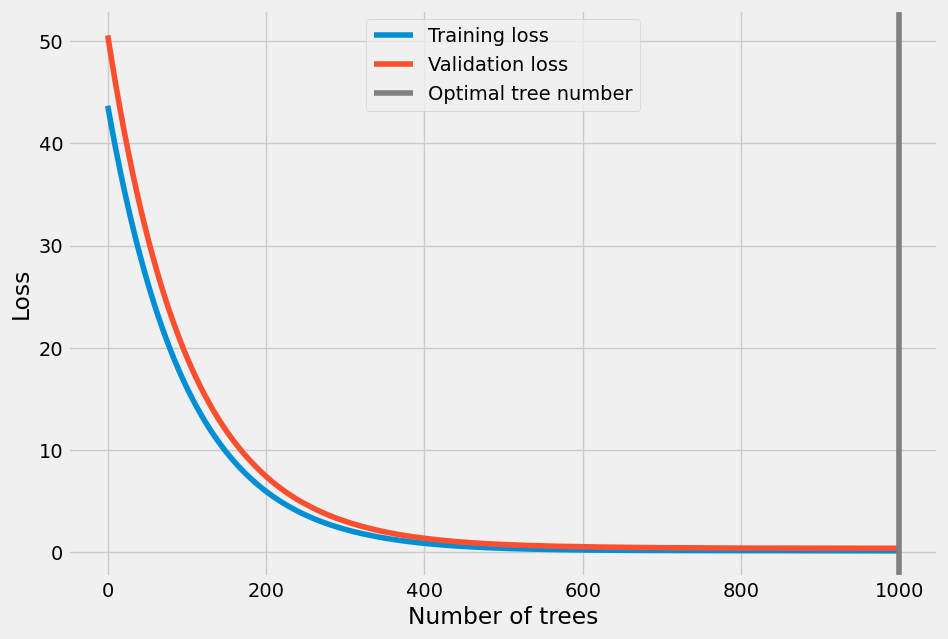

In [23]:
results = reg.evals_result()


plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(reg.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [24]:
reg.best_iteration

999

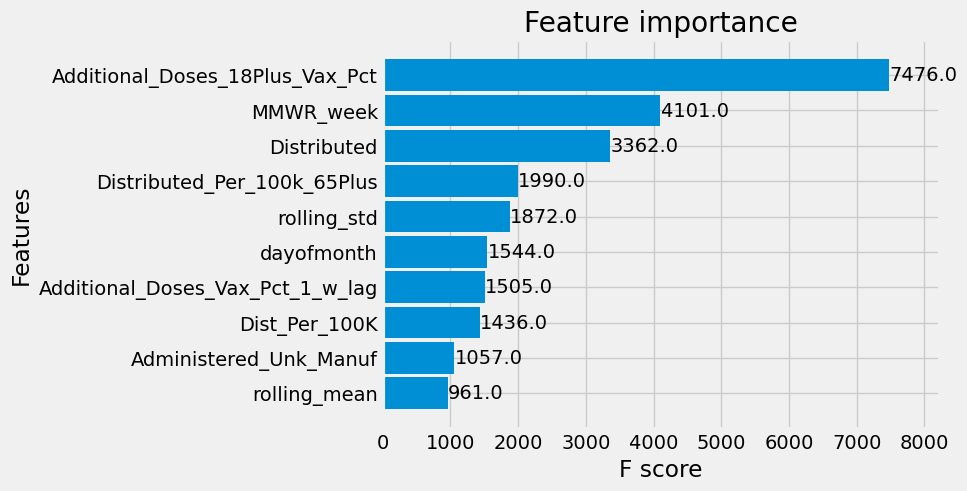

In [31]:
_ = plot_importance(reg, height=0.9 ,max_num_features = 10)

# Round 3 Tuning and adding more lags

In [2]:
# Import data
df = pd.read_csv('df_post_eda.csv')

# Sorting data by date and state
df = df.sort_values(by=['Date', 'Location'])

# Predictive variable
pred_var = 'Additional_Doses_Vax_Pct' 
df['Date'] = pd.to_datetime(df['Date'])

Decided to remove 6 month lag because of high correlation

In [3]:
# Additional time-series columns to account for 3-month pattern
# 3 month lag
df['Additional_Doses_Vax_Pct_3_m_lag'] = df['Additional_Doses_Vax_Pct'].shift(12)

# # 6 month lag
# df['Additional_Doses_Vax_Pct_6_m_lag'] = df['Additional_Doses_Vax_Pct'].shift(24)

# 9 month lag
df['Additional_Doses_Vax_Pct_9_m_lag'] = df['Additional_Doses_Vax_Pct'].shift(36)

# Rolling statistics
df['rolling_mean'] = df[pred_var].shift().rolling(window=12).mean()
df['rolling_std'] = df[pred_var].shift().rolling(window=12).std()

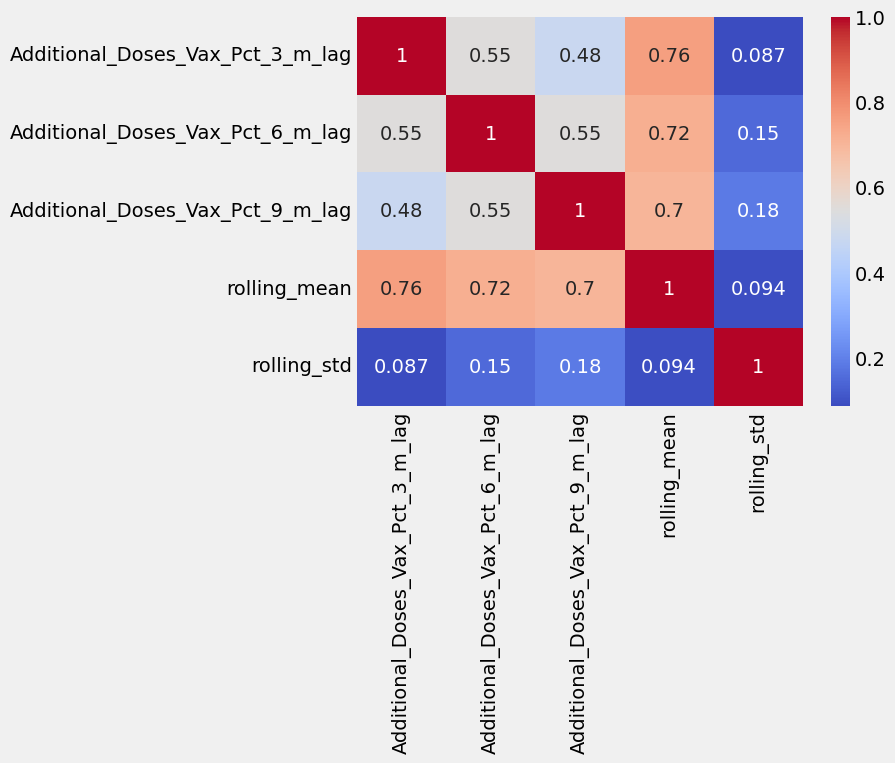

In [28]:
# Correlation matrix
corr_matrix = df[['Additional_Doses_Vax_Pct_3_m_lag', 'Additional_Doses_Vax_Pct_6_m_lag', 'Additional_Doses_Vax_Pct_9_m_lag', 'rolling_mean', 'rolling_std']].corr()

# Visualize the matrix with a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [4]:
# One-hot encoding of the entire dataframe
df_encoded = pd.get_dummies(df)

# Split the dataset based on unique dates
splits_by_date = [df_encoded[df_encoded['Date'] == date] for date in df_encoded['Date'].unique()]

# TimeSeriesSplit
# I made the test_size = 4 because I think a month's worth of data is sufficient

tscv = TimeSeriesSplit(n_splits=5, test_size = 12, gap = 12)

for train_index, test_index in tscv.split(splits_by_date):
    train = pd.concat([splits_by_date[i] for i in train_index])
    test = pd.concat([splits_by_date[i] for i in test_index])


In [5]:
# Set up XGBoost data structures
X_train, y_train = train.drop([pred_var, 'Date'], axis=1), train[pred_var]
X_test, y_test = test.drop([pred_var, 'Date'], axis=1), test[pred_var]

In [6]:
# Define hyperparameter search space
param_dist = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.3],
    'max_depth': np.arange(3, 10, 1),
    'min_child_weight': np.arange(1, 6, 1),
    'gamma': np.linspace(0, 0.5, 5),
    'subsample': np.linspace(0.5, 1, 5),
    'colsample_bytree': np.linspace(0.5, 1, 5),
    'reg_alpha': np.logspace(-5, 1, 5),
    'reg_lambda': np.logspace(-5, 1, 5)
}


In [7]:
# Initialize XGBoost regressor
reg = xgb.XGBRegressor(n_estimators=1000)

# Initialize RandomizedSearchCV and fit
random_search = RandomizedSearchCV(
    reg, param_distributions=param_dist, n_iter=50,
    scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=3, random_state=42
)

random_search.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a futur

KeyboardInterrupt: 

In [9]:
# Print best parameters

print(f"Best parameters found: {random_search.best_params_}")
print(f"Lowest RMSE found: {np.sqrt(np.abs(random_search.best_score_))}")

Best parameters found: {'subsample': 0.75, 'reg_lambda': 0.31622776601683794, 'reg_alpha': 10.0, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0.25, 'colsample_bytree': 1.0}
Lowest RMSE found: 0.8684627487883144


In [10]:
# Evaluate with cross-validation (xgb.cv)
dtrain = xgb.DMatrix(X_train, label=y_train)

cv_results = xgb.cv(
    random_search.best_params_,
    dtrain,
    num_boost_round=1000,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)

print(f"Final cross-validated RMSE: {cv_results['test-rmse-mean'].tail(1).values[0]}")


Final cross-validated RMSE: 0.290596


# Second Randomized Search CV

In [6]:
# Best parameters from RandomizedSearchCV
best_params = {
    'subsample': 0.75,
    'reg_lambda': 0.31622776601683794,
    'reg_alpha': 10.0,
    'min_child_weight': 1,
    'max_depth': 9,
    'learning_rate': 0.01,
    'gamma': 0.25,
    'colsample_bytree': 1.0
}

# Define a narrower search space centered around the best parameters
param_dist = {
    'learning_rate': [0.008, 0.01, 0.012],  # 0.8, 1.0 and 1.2 times 0.01
    'max_depth': [8, 9, 10],  # 9 minus 1, 9, 9 plus 1
    'min_child_weight': [1, 2],  # 1 and 1 plus 1
    'gamma': [0.2, 0.25, 0.3],  # 0.8, 1.0 and 1.2 times 0.25
    'subsample': [0.6, 0.75, 0.9],  # 0.8, 1.0 and 1.2 times 0.75
    'colsample_bytree': [0.8, 1.0],  # 0.8 and 1 times 1.0
    'reg_alpha': [5.0, 10.0, 20.0],  # 0.5, 1.0 and 2 times 10.0
    'reg_lambda': [0.158, 0.316, 0.632]  # 0.5, 1.0 and 2 times 0.316
}

# Initialize XGBoost regressor
reg = xgb.XGBRegressor(n_estimators=1000)

# Initialize RandomizedSearchCV and fit
random_search = RandomizedSearchCV(
    reg, param_distributions=param_dist, n_iter=50,
    scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=3, random_state=42
)

random_search.fit(X_train, y_train)

# Print best parameters

print(f"Best parameters found: {random_search.best_params_}")
print(f"Lowest RMSE found: {np.sqrt(np.abs(random_search.best_score_))}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a futur

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

In [ ]:
# Evaluate with cross-validation (xgb.cv)
dtrain = xgb.DMatrix(X_train, label=y_train)

cv_results = xgb.cv(
    random_search.best_params_,
    dtrain,
    num_boost_round=1000,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)

print(f"Final cross-validated RMSE: {cv_results['test-rmse-mean'].tail(1).values[0]}")
